<a href="https://colab.research.google.com/github/gsfreitas/engenharia-medica/blob/main/atividade_pratica_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Funções e bibliotecas

In [26]:
# importando as bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import shapiro
import itertools
import scipy.io
import scipy.fft as fft
from scipy.signal import welch
from sklearn import svm
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [59]:
def t8_SVM(X, classesX, C=0.1, kernel='linear', tol=0.001, gamma='scale'):
    # Treina uma SVM em um conjunto de dados X
    # INPUTS:
    # - X: matriz padrões x características
    # - classesX: vetor com as classes dos padrões (0 ou 1)
    # - C, kernel e tol são os parâmetros da SVM
    #   (C é o parâmetro de penalização do termo de erro, kernel especifica o tipo de kernel,
    #   tol é a tolerância para a otimização e gamma controla o tamanho da margem)
    # OUTPUTS:
    # - clf: objeto da SVM treinado
    # - txerro: erro de treinamento

    # Cria um objeto SVM com os parâmetros especificados
    clf = svm.SVC(C=C, kernel=kernel, tol=tol, gamma=gamma)

    # Treina o SVM com os dados fornecidos
    clf.fit(X, classesX)

    # Imprime o número de vetores de suporte para cada classe
    for i in range(len(clf.n_support_)):
        print('Número de vetores de suporte para a classe ' + str(i) + ': ' + str(clf.n_support_[i]))

    # Faz previsões nos dados de treinamento
    y = clf.predict(X)

    # Calcula a taxa de erro de treinamento
    txerro = sum(y != classesX) / classesX.size
    print('Taxa de erro de treinamento: ' + str(100 * txerro) + '%')

    return clf, txerro

In [27]:
def obter_indices_kfold(matriz, k, fold_desejado):
    # Inicializa o objeto KFold
    kf = KFold(n_splits=k, shuffle=True)

    # Itera sobre os folds
    for i, (train_index, val_index) in enumerate(kf.split(matriz[0])):
        if i == fold_desejado:
            # Retorna os índices de treinamento e validação do fold desejado
            return train_index, val_index

In [46]:
def avaliaclasslinear(w,classenegativa,classepositiva):
    #w = matriz de pesos do classificador linear em L+1 dimensoes
    #classe1 = matriz L x N1 da classe negativa
    #classe2 = matriz L x N2 da classe positiva
    # fp = percentual de falsos positivos
    # fn = percentual de falsos negativos
    # acc = acurácia do classificador
    (_,N1) = np.shape(classenegativa)
    (_,N2) = np.shape(classepositiva)
    classenegativa=np.vstack((classenegativa,np.ones(N1)))
    classepositiva=np.vstack((classepositiva,np.ones(N2)))
    prevneg=np.sign(w @ classenegativa)
    prevpos=np.sign(w @ classepositiva)
    fp = 100*np.sum(prevneg>=0)/N1
    fn = 100*np.sum(prevpos<0)/N2
    vp = 100 - fn
    vn = 100 - fp
    # Sensibilidade
    sensibilidade = vp / (vp + fn) * 100
    # Especificidade
    especificidade = vn / (vn + fp) * 100
    acc = 100*(np.sum(prevneg<0) + np.sum(prevpos>=0))/(N1+N2)
    if acc<50: # classe negativa e positiva estao trocadas
        fp,fn,acc=avaliaclasslinear(w,classepositiva,classenegativa)
    return fp, fn, vp, vn, sensibilidade, especificidade, acc

In [29]:
def t4_svd(dados,m):
    #Realiza a transformação do espaço de características usando a PCA:
    #Inputs:
    # - dados= matriz L x N (caracteristicas x padroes)
    # - m = dimensão do espaço de componentes principais
    #Outputs:
    # - w = autovalores
    # - v = autovetores
    # - mse = erro quadrático médio da projeção
    # - dadosproj = matriz contendo os dados projetados

    # Inicializa uma matriz de zeros do mesmo formato que dados
    dadosnm=np.zeros_like(dados)

    # Normaliza os dados em relação à média em cada característica (linha)
    for i in range(np.size(dadosnm,axis=0)):
        dadosnm[i,:]=dadosnm[i,:]-np.mean(dadosnm[i,:])

    # Realiza a decomposição de valores singulares (SVD)
    U,D,VT=np.linalg.svd(dadosnm)

    # Calcula os autovalores
    w=D**2/np.size(dadosnm,axis=1)

    # Obtém os índices dos autovalores em ordem decrescente
    comps=w.argsort()[::-1] #ordem decrescente

    # Seleciona os primeiros m índices para os componentes principais
    comps=list(comps[0:m])

    # Obtém os autovetores correspondentes
    v=U[:,comps]

    # Projeta os dados no novo espaço de características
    dadosproj=np.dot(v.T,dadosnm)

    # Se m é igual a 1, retorna uma matriz unidimensional em vez de uma matriz bidimensional
    if m==1:
         dadosproj=dadosproj[0]

    # Calcula o erro quadrático médio da projeção
    mse=100*(1-sum(w[comps])/sum(w))

    # Retorna os autovalores, o erro quadrático médio, os dados projetados e os autovetores
    w=w[comps]
    return w,mse,dadosproj,v

In [30]:
def t6_perceptron(classe1, classe2, rho=0.05, maxsteps=10000):
    # Implementação do Perceptron para duas classes
    # INPUTS:
    # - classe1: L x N1 da primeira classe (características x padrões)
    # - classe2: L x N2 da segunda classe (características x padrões)
    # - rho: parâmetro de aprendizado (learning rate)
    # - maxsteps: número máximo de iterações
    # OUTPUT:
    # - ws: vetor com os pesos do classificador
    # - hs: indica se o perceptron convergiu (=0) ou não convergiu (número de erros do perceptron)
    # - t: número de iterações realizadas

    L1, N1 = np.shape(classe1)
    L2, N2 = np.shape(classe2)

    # Verifica se as classes têm o mesmo número de características
    if L1 != L2:
        print('ERRO: Classes devem ter o mesmo número de características')
        return

    # Combina as duas classes e adiciona uma linha de uns para o termo de viés
    X = np.hstack((classe1, classe2))
    C = np.hstack((-np.ones(N1,), np.ones(N2,)))
    X = np.vstack((X, np.ones((1, N1 + N2))))

    # Inicializa os pesos aleatoriamente
    w = np.random.randn(L1 + 1,)
    ws = w

    def classifica(w, X, C):
        # Função para classificar os padrões e calcular os erros
        res = np.sign(np.dot(w.T, X))
        Y = X[:, res * C <= 0]
        CY = -C[res * C <= 0]
        return Y, CY

    # Inicializa as variáveis de erro e iteração
    (Y, CY) = classifica(w, X, C)
    hs = np.shape(Y)[1]
    t = 0

    # Loop de treinamento do perceptron
    while ((hs > 0) & (t < maxsteps)):
        for i in range(L1 + 1):
            w[i] = w[i] - np.sum(rho * Y[i, :] * CY)

        [Y, CY] = classifica(w, X, C)
        t = t + 1
        ht = np.shape(Y)[1]

        # Atualiza a variável de erro
        if ht < hs:
            hs = ht
            ws = w

    # Verifica se o perceptron convergiu
    if hs == 0:
        print('Perceptron convergiu')
    else:
        print('Limite de iterações atingido')

    return ws, hs, t

In [31]:
def t4_pca(dados, m):
    # Realiza a transformação do espaço de características usando a PCA:
    # Inputs:
    # - dados = matriz L x N (caracteristicas x padroes)
    # - m = dimensão do espaço de componentes principais
    # Outputs:
    # - w = autovalores
    # - v = autovetores
    # - mse = erro quadrático médio da projeção
    # - dadosproj = matriz contendo os dados projetados

    # Calcula a matriz de covariância
    Sigma = np.cov(dados, ddof=0)

    # Calcula os autovalores (w) e autovetores (v) da matriz de covariância
    w, v = np.linalg.eigh(Sigma)  # v: colunas são os autovetores

    # Ordena em ordem decrescente
    comps = w.argsort()[::-1]
    comps = list(comps[0:m])

    # Seleciona os autovetores correspondentes ao número desejado de componentes principais (m)
    v = v[:, comps]

    # Projeta os dados no novo espaço de características
    dadosproj = np.dot(v.T, dados)

    # Reduz a dimensão para 1D se m for igual a 1
    if m == 1:
        dadosproj = dadosproj[0]

    # Calcula o erro quadrático médio da projeção
    mse = 100 * (1 - sum(w[comps]) / sum(w))

    # Retorna os resultados
    w = w[comps]
    return w, mse, dadosproj, v

In [32]:
def t3_matrizesdeespalhamento(classes, selcars):
    # Calcula as matrizes de espalhamento a partir de uma lista de classes
    # Inputs:
    # - classes = lista em que cada elemento corresponde a um array características x padrões de cada classe
    # - selcars = índice de quais características usar no cálculo das matrizes
    # Outputs:
    # - matrizes de espalhamento: SW, SM e SB

    Ncl = len(classes)
    mean_vectors = []

    # Calcula os vetores médios de cada classe
    for cl in range(Ncl):
        mean_vectors.append(np.mean(classes[cl][selcars, :], axis=1))

    prob = np.zeros(Ncl)
    N = 0

    # Calcula as probabilidades de cada classe
    for i in range(Ncl):
        prob[i] = np.size(classes[i][selcars, :], axis=1)
        N = N + prob[i]

    prob = prob / N
    Ncar = len(selcars)
    SW = np.zeros((Ncar, Ncar))  # within classes

    # Calcula a matriz de espalhamento dentro das classes (SW)
    for cl in range(Ncl):
        varwithin = np.cov(classes[cl][selcars, :], ddof=0)
        SW = SW + prob[cl] * varwithin

    # Concatena todas as classes em uma única matriz
    allclasses = classes[0][selcars, :]
    for cl in range(Ncl - 1):
        allclasses = np.concatenate((allclasses, classes[cl + 1][selcars, :]), axis=1)

    # Calcula a matriz de espalhamento total (SM)
    SM = np.cov(allclasses, ddof=0)

    # Calcula a matriz de espalhamento entre as classes (SB)
    SB = SM - SW

    return SW, SM, SB

In [33]:
def t7_FDA(classes, n):
    # Encontra a transformação para o espaço da Análise Discriminante Linear de Fisher entre classes distintas
    # INPUT:
    # - classes: lista de classes. classes[i] = (L x Ni): L características e Ni padrões na classe i
    # - n = número de características para selecionar
    # OUTPUT:
    # - A: matriz de projeção (as colunas são os vetores de projeção para o novo espaço)
    # - Lambda: autovalores

    C = len(classes)
    L = np.size(classes[0], axis=0)

    # Verifica se todas as classes têm a mesma dimensão
    for i in range(C):
        if np.size(classes[i], axis=0) != L:
            print('ERRO: Confira a dimensão das variáveis de input')
            return

    # Calcula as matrizes de espalhamento
    SW, SM, SB = t3_matrizesdeespalhamento(classes, range(L))

    # Calcula os autovalores e autovetores da matriz generalizada
    (Lambda, Vec) = np.linalg.eig(np.dot(np.linalg.inv(SW), SB))

    # Ordena os autovalores e autovetores em ordem decrescente
    s = Lambda.argsort()
    Lambda = Lambda[s[::-1]]
    Vec = Vec[:, s[::-1]]

    # Seleciona as n primeiras colunas dos autovetores
    A = np.real(Vec[:, 0:n])
    Lambda = Lambda[0:n]

    return A, Lambda

# Teste completo de um classificador

No arquivo Dados.mat disponível no Classroom do curso você encontra duas variáveis, “Saudável” e “Patologico”, correspondendo a duas classes em um espaço de 1000 características, já pré-processadas. Nesta atividade você deverá realizar o teste completo de estratégias de classificação unidimensionais usando a FDA.

**A)** Para isso, você deve treinar pelo menos duas estratégias diferentes de classificação nestes dados que utilizem a FDA e validar os hiperparâmetros do seu classificador com uma validação cruzada 3-fold repetida 10 vezes. Reporte os resultados da sua validação, selecionando a estratégia que você julgar melhor.

In [34]:
# lendo os dados e transpondo para ficar no formato carac x padrao
patologico = scipy.io.loadmat(r'/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-9/dados.mat')['Patologico'].T
patologico_teste = scipy.io.loadmat(r'/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-9/dados.mat')['Patologico_teste'].T

saudavel = scipy.io.loadmat(r'/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-9/dados.mat')['Saudavel'].T
saudavel_teste = scipy.io.loadmat(r'/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-9/dados.mat')['Saudavel_teste'].T

Inicialmente vamos verificar se as classes são linearmente separáveis utilizando o Perceptron. Caso ele venha a convergir, então as classes são separáveis. Contudo, caso ele atinja o número máximo de iterações, então é necessário realizar a redução de dimensionalidade

In [35]:
# calculando o perceptron para as duas classes
ws, hs, t = t6_perceptron(saudavel, patologico, rho=0.05, maxsteps=10000)

Perceptron convergiu


Podemos perceber que o perceptron convergiu! COntudo, devemos reduzir a dimensão dos dados, uma vez que para utilizar o Análise Discriminante de Fisher devemos garantir que a matriz de espalhamento intra-classe seja invesível,o que pode não ocorrer se trabalhássemos em 1000 dimensões.

Para realizar a transformação do espaço de características e reduzir a dimensão, utilizaremos a PCA como estratégia principal para isso.

In [36]:
# juntando todos os dados
dados = np.hstack([saudavel, patologico])

# implementando o label das classes
classe_saudavel = np.zeros_like(saudavel[0,:])
classe_patologico = np.ones_like(patologico[0,:])

Vamos escolher m = 93, por representar 2/3 dos dados para que não haja problema ao rodar o 3 folds.

In [37]:
# juntando as duas classes em uma lista
classes = np.hstack([classe_saudavel, classe_patologico])

# calculando a PCA
w, mse, dadosproj, v = t4_pca(dados, m=93)

In [38]:
# separando as classes com base no novo espaço projetado pela PCA
saudavel = dadosproj.T[classes == 0].T
patologico = dadosproj.T[classes == 1].T

In [39]:
# juntando novamente os novos dados em uma lista
dados_new = [saudavel, patologico]

# calculando a FDA para projetar os dados em 1 dimensão
A, Lambda = t7_FDA(dados_new, n=1)

# projetando os dados na nova dimensao
dadosproj_FDA = np.dot(A.T, dadosproj)

In [40]:
# separando as classes a partir do novo espaco da FDA
saudavel_FDA = dadosproj_FDA.T[classes == 0]
patologico_FDA = dadosproj_FDA.T[classes == 1]

In [41]:
saudavel_FDA.shape

(70, 1)

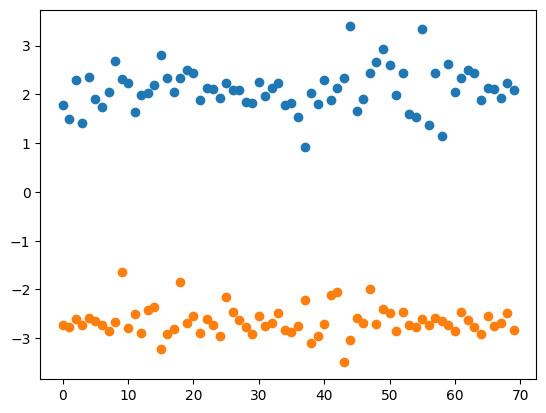

In [42]:
# plot do espaco da FDA
plt.figure()
plt.scatter(np.arange(0, len(saudavel_FDA),1), saudavel_FDA[:,0])
plt.scatter(np.arange(0, len(patologico_FDA),1), patologico_FDA[:,0])
plt.show()

In [56]:
# Defina o número de repetições (10 no seu caso)
num_repeticoes = 10
k = 3

# Inicialize as listas para armazenar os resultados
Sensibilidades_perceptron_train = []
Especificidades_perceptron_train = []
Fn_perceptron_train = []
Fp_perceptron_train = []
Vp_perceptron_train = []
Vn_perceptron_train = []
Sensibilidades_perceptron_train = []
Especificidades_perceptron_train = []
Acc_perceptron_train = []

Sensibilidades_perceptron_val = []
Especificidades_perceptron_val = []
Fn_perceptron_val = []
Fp_perceptron_val = []
Vp_perceptron_val = []
Vn_perceptron_val = []
Sensibilidades_perceptron_val = []
Especificidades_perceptron_val = []
Acc_perceptron_val = []


Fn_svm_train = []
Fp_svm_train = []
Vp_svm_train = []
Vn_svm_train = []
Sensibilidades_svm_train = []
Especificidades_svm_train = []
Acc_svm_train = []


Fn_svm_val = []
Fp_svm_val = []
Vp_svm_val = []
Vn_svm_val = []
Sensibilidades_svm_val = []
Especificidades_svm_val = []
Acc_svm_val = []

In [57]:
# zera os parametros de acuracia
Acc_melhor_w = 0
Acc_melhor_clf = 0

In [60]:
for i in range(num_repeticoes):
    for fold_desejado in range(k):
        np.random.seed(i)
        train_index, val_index = obter_indices_kfold(dadosproj_FDA, k, fold_desejado=fold_desejado)

        fold_treino = dadosproj_FDA[:,train_index]
        fold_val = dadosproj_FDA[:, val_index]
        classes_treino = classes[train_index]
        classes_val = classes[val_index]

        # Perceptron
        # Treinamento
        Saudavel_treino = fold_treino.T[classes_treino == 0].T
        Patologico_treino = fold_treino.T[classes_treino == 1].T

        ws, hs, t = t6_perceptron(Saudavel_treino, Patologico_treino, rho=0.01, maxsteps=10000)

        Fn, Fp, Vp, Vn, sensibilidade, especificidade, Acc_train_p = avaliaclasslinear(ws,Saudavel_treino,Patologico_treino)
        Fn_perceptron_train.append(Fn)
        Fp_perceptron_train.append(Fp)
        Vp_perceptron_train.append(Vp)
        Vn_perceptron_train.append(Vn)
        Sensibilidades_perceptron_train.append(sensibilidade)
        Especificidades_perceptron_train.append(especificidade)
        Acc_perceptron_train.append(Acc_train_p)


        # Validacao
        Saudavel_val = fold_val.T[classes_val == 0].T
        Patologico_val = fold_val.T[classes_val == 1].T
        Fn, Fp, Vp, Vn, sensibilidade, especificidade, Acc = avaliaclasslinear(ws,Saudavel_val,Patologico_val)
        Fn_perceptron_val.append(Fn)
        Fp_perceptron_val.append(Fp)
        Vp_perceptron_val.append(Vp)
        Vn_perceptron_val.append(Vn)
        Sensibilidades_perceptron_val.append(sensibilidade)
        Especificidades_perceptron_val.append(especificidade)
        Acc_perceptron_val.append(Acc)


        if Acc_melhor_w > Acc_train_p:
            continue
        else:
            melhor_w = ws
            Acc_melhor_w = Acc_train_p

        # SVM
        clf, txerro = t8_SVM(fold_treino.T, classes_treino, C=2)
        predicoes = clf.predict(fold_treino.T)
        conf_matrix_svm = confusion_matrix(classes_treino, predicoes)
        Fn = conf_matrix_svm[1,0]
        Fp= conf_matrix_svm[0,1]
        Vp = conf_matrix_svm[0,0]
        Vn = conf_matrix_svm[1,1]
        # Sensibilidade
        sensibilidade = Vp / (Vp + Fn) * 100
        # Especificidade
        especificidade = Vn / (Vn + Fp) * 100

        Acc_train_svm = (Vp+Vn) / (Vp+Vn+Fp+Fn)

        Fn_svm_train.append(Fn)
        Fp_svm_train.append(Fp)
        Vp_svm_train.append(Vp)
        Vn_svm_train.append(Vn)
        Sensibilidades_svm_train.append(sensibilidade)
        Especificidades_svm_train.append(especificidade)
        Acc_svm_train.append(Acc_train_svm)

        # Validacao
        predicoes = clf.predict(fold_val.T)
        conf_matrix_svm = confusion_matrix(classes_val, predicoes)
        Fn = conf_matrix_svm[1,0]
        Fp= conf_matrix_svm[0,1]
        Vp = conf_matrix_svm[0,0]
        Vn = conf_matrix_svm[1,1]
        # Sensibilidade (Recall)
        sensibilidade = Vp / (Vp + Fn) * 100
        # Especificidade
        especificidade = Vn / (Vn + Fp) * 100

        acc = (Vp+Vn) / (Vp+Vn+Fp+Fn)

        Fn_svm_val.append(Fn)
        Fp_svm_val.append(Fp)
        Vp_svm_val.append(Vp)
        Vn_svm_val.append(Vn)
        Sensibilidades_svm_val.append(sensibilidade)
        Especificidades_svm_val.append(especificidade)
        Acc_svm_val.append(acc)

        if Acc_melhor_clf > Acc_train_svm:
            continue
        else:
            melhor_clf = clf
            Acc_melhor_clf = Acc_train_svm

Perceptron convergiu
Número de vetores de suporte para a classe 0: 1
Número de vetores de suporte para a classe 1: 1
Taxa de erro de treinamento: 0.0%
Perceptron convergiu
Número de vetores de suporte para a classe 0: 1
Número de vetores de suporte para a classe 1: 1
Taxa de erro de treinamento: 0.0%
Perceptron convergiu
Número de vetores de suporte para a classe 0: 1
Número de vetores de suporte para a classe 1: 1
Taxa de erro de treinamento: 0.0%
Perceptron convergiu
Número de vetores de suporte para a classe 0: 1
Número de vetores de suporte para a classe 1: 1
Taxa de erro de treinamento: 0.0%
Perceptron convergiu
Número de vetores de suporte para a classe 0: 1
Número de vetores de suporte para a classe 1: 1
Taxa de erro de treinamento: 0.0%
Perceptron convergiu
Número de vetores de suporte para a classe 0: 1
Número de vetores de suporte para a classe 1: 1
Taxa de erro de treinamento: 0.0%
Perceptron convergiu
Número de vetores de suporte para a classe 0: 1
Número de vetores de supo

Vemos que ambos os métodos de classificao apresentaram bons resultados, porém para este caso apos a FDA, nosso conjunto de dados é pequeno e possuimos apenas 1 caracteristica, tendo assim o perceptron como melhor escolha, uma vez que seu custo computacional é menor.

In [61]:
# unindo os dados de teste
dados_teste = np.hstack([saudavel_teste, patologico_teste])

# separando as classes de teste
classe_saud_teste = np.zeros_like(saudavel_teste[0,:])
classe_pato_teste = np.ones_like(patologico_teste[0,:])

In [63]:
# projetando os dados
dadosproj = np.dot(v.T, dados_teste)

# juntando as classes após a projecao
classes_teste = np.hstack([classe_saud_teste, classe_pato_teste])
dadosproj_FDA_teste = np.dot(A.T, dadosproj)

Saudavel_teste = dadosproj_FDA_teste.T[classes_teste == 0].T
Patologico_teste = dadosproj_FDA_teste.T[classes_teste == 1].T
Fn, Fp, Vp, Vn, sensibilidade, especificidade, Acc = avaliaclasslinear(melhor_w,Saudavel_teste,Patologico_teste)

In [66]:
print(f"Taxa de Falso Positivo: {Fp}%")
print(f"Taxa de Falso Negativo: {Fn}%")
print(f"Acurária: {Acc}%")
print(f"Sensibilidade: {sensibilidade}%")
print(f"Especificidade: {especificidade}%")

Taxa de Falso Positivo: 0.0%
Taxa de Falso Negativo: 2.6315789473684212%
Acurária: 98.18181818181819%
Sensibilidade: 100.0%
Especificidade: 97.36842105263158%
